<a href="https://colab.research.google.com/github/RealYarik/ard/blob/main/TwittSentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Twitter Sentiment Analysis**

# **In this task, we will load and preprocess tweets data from a dataset.We will then create an RNN using the LSTM training pass for the model.The goal is to predict the sentiment On Twitter.** 


# Libraries


In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Create the Dataset**
We use this DataSet https://www.kaggle.com/kazanova/sentiment140

In [4]:
df = pd.read_csv('/content/drive/MyDrive/training.1600000.processed.noemoticon.csv',
                 encoding = 'latin',header=None)
df.head()
df.columns = ['sentiment', 'id', 'date', 'query', 'user_id', 'text']
df.head()

,sentiment,id,date,query,user_id,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [5]:
df = df.drop(['id', 'date', 'query', 'user_id'], axis=1)

In [6]:
lab_to_sentiment = {0:"Negative", 4:"Positive"}
def label_decoder(label):
  return lab_to_sentiment[label]
df.sentiment = df.sentiment.apply(lambda x: label_decoder(x))
df.head()

,sentiment,text
0,Negative,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,Negative,is upset that he can't update his Facebook by ...
2,Negative,@Kenichan I dived many times for the ball. Man...
3,Negative,my whole body feels itchy and like its on fire
4,Negative,"@nationwideclass no, it's not behaving at all...."


Text(0.5, 1.0, 'Sentiment Data Distribution')

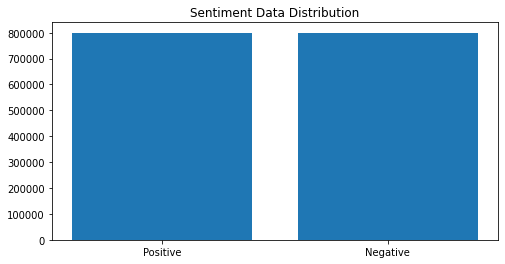

In [7]:
val_count = df.sentiment.value_counts()
plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Sentiment Data Distribution")

In [8]:
import random
random_idx_list = [random.randint(1,len(df.text)) for i in range(10)] # creates random indexes to choose from dataframe
df.loc[random_idx_list,:].head(10) # Returns the rows with the index and display it

,sentiment,text
1035622,Positive,loved the previews of JBs new songs cant wait ...
1259481,Positive,@kirstiealley ROTFLMAO!!! Too funny!
1513968,Positive,@wiinx oh iya are u really the one.. hahaa.. g...
613989,Negative,"Bored bored bored, want a job! Bought some B..."
1493929,Positive,@kiwikaty aww thanks xo She was v weirded out ...
1101519,Positive,"@wanderblah Dadar West, the furniture galli ne..."
974830,Positive,"i have finished my research paper!!! also, thi..."
933867,Positive,Red Devils r a point away frm glory... wil b c...
373195,Negative,Its official: were moving to murrieta in 30 d...
1116908,Positive,@TomFelton hahhaha i know huh? when you look a...


In [9]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')
text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

In [10]:
def preprocess(text, stem=False):
  text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
  tokens = []
  for token in text.split():
    if token not in stop_words:
      if stem:
        tokens.append(stemmer.stem(token))
      else:
        tokens.append(token)
  return " ".join(tokens)

In [11]:
df.text = df.text.apply(lambda x: preprocess(x))

# WORDCLOUD OF Negative TWEETS


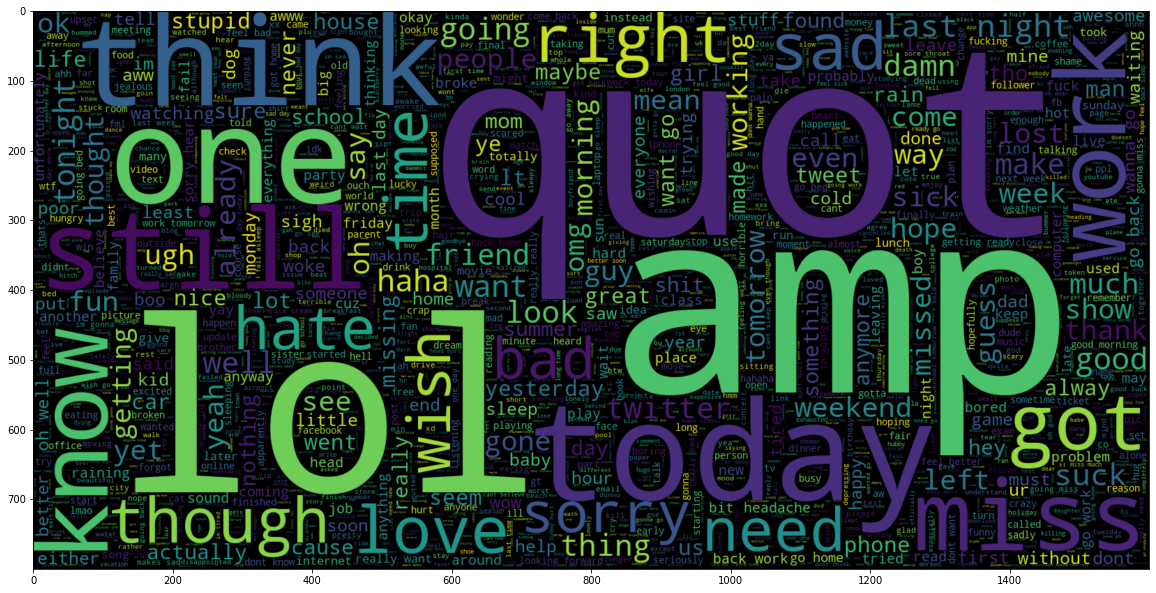

In [11]:
from wordcloud import WordCloud

plt.figure(figsize = (20,20)) 
wcn=WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment == 'Negative'].text))
plt.imshow(wcn , interpolation = 'bilinear')

# WORDCLOUD OF Positive TWEETS


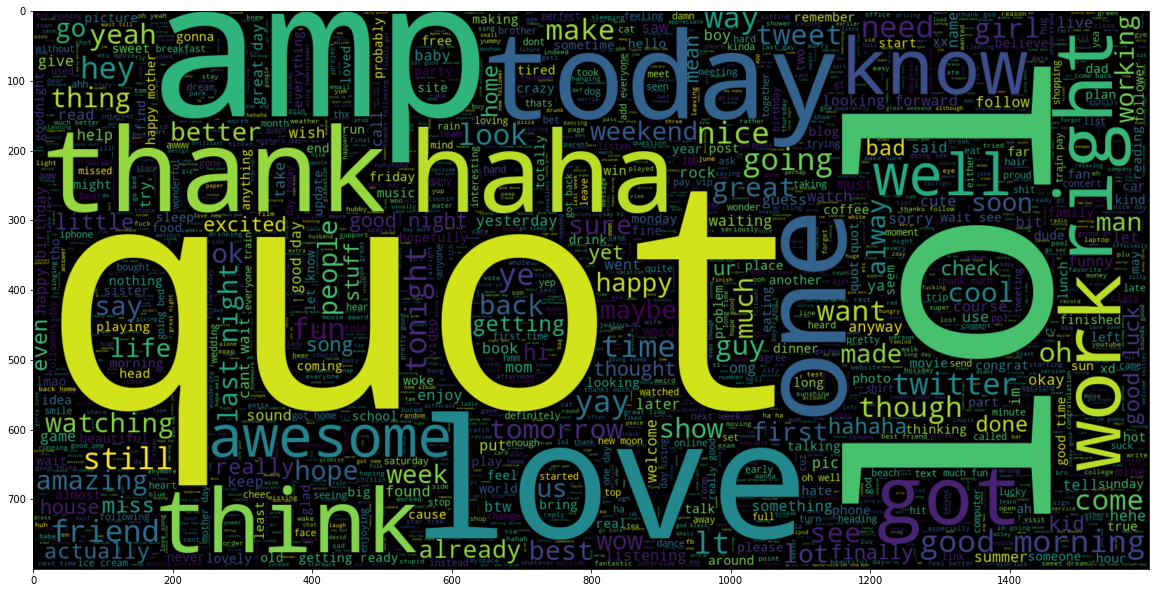

In [12]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment == 'Positive'].text))
plt.imshow(wc , interpolation = 'bilinear')

In [12]:
TRAIN_SIZE = 0.8
MAX_NB_WORDS = 100000
MAX_SEQUENCE_LENGTH = 30

# **Train data**

In [13]:
train_data, test_data = train_test_split(df, test_size=1-TRAIN_SIZE,
                                         random_state=7) # Splits Dataset into Training and Testing set
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))
train_data.head(10)

Train Data size: 1280000
Test Data size 320000


,sentiment,text
23786,Negative,need friends
182699,Negative,im trying call impossible
476661,Negative,good pace going 3k 13 min missed 5k turn ended...
1181490,Positive,u gonna shows ny soon luv see u live
878773,Positive,hell yea get em tattoos ink free wish parents ...
130866,Negative,yeah need 2 see ur mom calls back first rememb...
1235876,Positive,sounds like cup tea sign
717314,Negative,tired want sleep wtf
969880,Positive,amazing wish
748698,Negative,thank god wkrn abc affiliate nashville back mi...


In [14]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.text)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 290575


In [15]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.text),
                        maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.text),
                       maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

Training X Shape: (1280000, 30)
Testing X Shape: (320000, 30)


In [16]:
labels = train_data.sentiment.unique().tolist()

In [17]:
encoder = LabelEncoder()
encoder.fit(train_data.sentiment.to_list())

y_train = encoder.transform(train_data.sentiment.to_list())
y_test = encoder.transform(test_data.sentiment.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (1280000, 1)
y_test shape: (320000, 1)


**We will use GloVe for obtaining vector representations for words (http://nlp.stanford.edu/data/glove.6B.zip).**

In [18]:
!unzip /content/drive/MyDrive/glove.6B.zip

Archive:  /content/drive/MyDrive/glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [19]:
GLOVE_EMB = 'glove.6B.300d.txt'
EMBEDDING_DIM = 300
LR = 1e-3
BATCH_SIZE = 1024
EPOCHS = 10
MODEL_PATH = 'best_model.hdf5'

In [20]:
embeddings_index = {}
f = open(GLOVE_EMB,encoding="utf8")
for line in f:
  values = line.split()
  word = value = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


In [21]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [22]:
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=MAX_SEQUENCE_LENGTH,
                                          trainable=False)

In [27]:
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout,concatenate,GlobalMaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint

# **Model.Compile.Train.Results.Predict**

In [28]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(64, 5, activation='relu')(x)
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(sequence_input, outputs)

In [29]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

model.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy',
              metrics=['accuracy'])
ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1,
                                     min_lr = 0.01,
                                     monitor = 'val_loss',
                                     verbose = 1)

In [30]:
print("Training on GPU...") if tf.test.is_gpu_available() else print("Training on CPU...")

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Training on GPU...


In [31]:
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_data=(x_test, y_test), callbacks=[ReduceLROnPlateau])

Epoch 1/10
1250/1250 [==============================] - 229s 175ms/step - loss: 0.5439 - accuracy: 0.7185 - val_loss: 0.4819 - val_accuracy: 0.7660
Epoch 2/10
1250/1250 [==============================] - 217s 174ms/step - loss: 0.4891 - accuracy: 0.7614 - val_loss: 0.4723 - val_accuracy: 0.7718
Epoch 3/10
1250/1250 [==============================] - 219s 175ms/step - loss: 0.4771 - accuracy: 0.7695 - val_loss: 0.4678 - val_accuracy: 0.7756
Epoch 4/10
1250/1250 [==============================] - 219s 176ms/step - loss: 0.4704 - accuracy: 0.7737 - val_loss: 0.4641 - val_accuracy: 0.7783
Epoch 5/10
1250/1250 [==============================] - 217s 174ms/step - loss: 0.4663 - accuracy: 0.7760 - val_loss: 0.4615 - val_accuracy: 0.7789
Epoch 6/10
1250/1250 [==============================] - 220s 176ms/step - loss: 0.4614 - accuracy: 0.7795 - val_loss: 0.4589 - val_accuracy: 0.7803
Epoch 7/10
1250/1250 [==============================] - 220s 176ms/step - loss: 0.4593 - accuracy: 0.7807 - val_

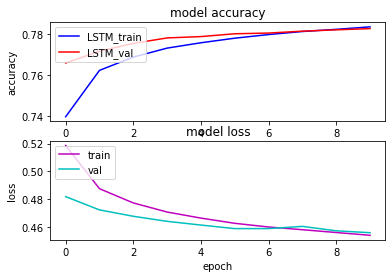

In [32]:
s, (at, al) = plt.subplots(2,1)
at.plot(history.history['accuracy'], c= 'b')
at.plot(history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], loc='upper left')

al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')

In [33]:
def decode_sentiment(score):
    return "Positive" if score>0.5 else "Negative"


scores = model.predict(x_test, verbose=1, batch_size=10000)
y_pred_1d = [decode_sentiment(score) for score in scores]

32/32 [==============================] - 8s 234ms/step


In [33]:
import itertools
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=13)
    plt.yticks(tick_marks, classes, fontsize=13)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=17)
    plt.xlabel('Predicted label', fontsize=17)

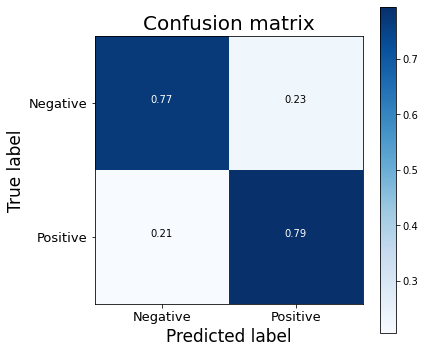

In [35]:
cnf_matrix = confusion_matrix(test_data.sentiment.to_list(), y_pred_1d)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=test_data.sentiment.unique(), title="Confusion matrix")
plt.show()

In [36]:
print(classification_report(list(test_data.sentiment), y_pred_1d))

              precision    recall  f1-score   support

    Negative       0.79      0.77      0.78    160542
    Positive       0.78      0.79      0.78    159458

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000



# **Model 2.Compile.Train.Results.Predict**

In [28]:
sequence_input2 = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_sequences2 = embedding_layer(sequence_input2)
x = SpatialDropout1D(0.2)(embedding_sequences2)
x = Bidirectional(LSTM(64, return_sequences=True, dropout=0.2))(x)
x = Bidirectional(LSTM(64, return_sequences=True, dropout=0.2))(x)
hidden = concatenate([
        GlobalMaxPooling1D()(x),
        GlobalAveragePooling1D()(x)
    ])

dense = Dense(512, activation='relu')(hidden)
dense = Dense(512, activation='relu')(dense)
outputs2 = Dense(1, activation='sigmoid')(dense)
model2 = tf.keras.Model(sequence_input2, outputs2)

In [29]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

model2.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy',
              metrics=['accuracy'])
ReduceLROnPlateau2 = ReduceLROnPlateau(factor=0.1,
                                     min_lr = 0.01,
                                     monitor = 'val_loss',
                                     verbose = 1)

In [30]:
history2 = model2.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_data=(x_test, y_test), callbacks=[ReduceLROnPlateau2])

Epoch 1/10
1250/1250 [==============================] - 71s 47ms/step - loss: 0.5387 - accuracy: 0.7224 - val_loss: 0.4699 - val_accuracy: 0.7743
Epoch 2/10
1250/1250 [==============================] - 58s 46ms/step - loss: 0.4800 - accuracy: 0.7667 - val_loss: 0.4597 - val_accuracy: 0.7808
Epoch 3/10
1250/1250 [==============================] - 58s 46ms/step - loss: 0.4684 - accuracy: 0.7746 - val_loss: 0.4542 - val_accuracy: 0.7842
Epoch 4/10
1250/1250 [==============================] - 58s 46ms/step - loss: 0.4608 - accuracy: 0.7789 - val_loss: 0.4501 - val_accuracy: 0.7857
Epoch 5/10
1250/1250 [==============================] - 58s 46ms/step - loss: 0.4554 - accuracy: 0.7825 - val_loss: 0.4462 - val_accuracy: 0.7892
Epoch 6/10
1250/1250 [==============================] - 58s 46ms/step - loss: 0.4526 - accuracy: 0.7845 - val_loss: 0.4462 - val_accuracy: 0.7897
Epoch 7/10
1250/1250 [==============================] - 58s 46ms/step - loss: 0.4485 - accuracy: 0.7863 - val_loss: 0.4429 -

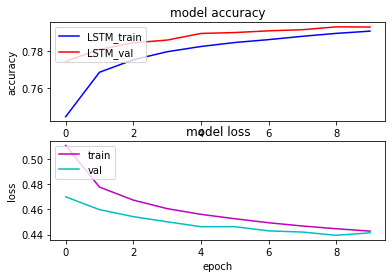

In [31]:
s, (at, al) = plt.subplots(2,1)
at.plot(history2.history['accuracy'], c= 'b')
at.plot(history2.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], loc='upper left')

al.plot(history2.history['loss'], c='m')
al.plot(history2.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')

In [32]:
def decode_sentiment(score):
    return "Positive" if score>0.5 else "Negative"


scores = model2.predict(x_test, verbose=1, batch_size=10000)
y_pred_1d2 = [decode_sentiment(score) for score in scores]

32/32 [==============================] - 7s 158ms/step


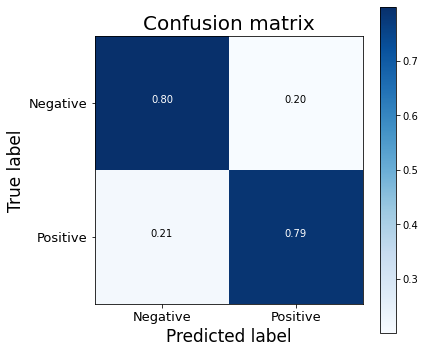

In [34]:
cnf_matrix = confusion_matrix(test_data.sentiment.to_list(), y_pred_1d2)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=test_data.sentiment.unique(), title="Confusion matrix")
plt.show()

# **Conclusion**

**We analyzed and predicted Twitter sentiment. If we develop this direction, then it is quite possible to achieve good results.**